In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
path_results = Path('/media/discoD/models/elmo/ner/harem_cbow_skip_2')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/harem_cbow_skip_2/harem


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            metrics[training_folder.name] = None
print(len(metrics))
print(len(configs))

8
8


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    if len(data) == 4:
        return {MODEL: data[0], EMBEDDING: data[1], EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        return {MODEL: data[0], EMBEDDING: data[1], EMBEDDING_TYPE: data[2], TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    else:
        print('Invalid id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Model,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem_FastText_cbow_0_0,harem,FastText,cbow,0,0,18,20,00:21:34,1294.0,64.70,0.996238,0.996574,0.956864,0.951187,0.954017,6.895696,0.979565,0.981860,0.820449,0.839286,0.829760,64.836776,0.977726,0.979587,0.826612,0.800668,0.813433,78.893459
1,harem_FastText_skip_0_0,harem,FastText,skip,0,0,17,20,00:21:17,1277.0,63.85,0.998813,0.998925,0.986250,0.986516,0.986383,2.618697,0.980549,0.982625,0.809639,0.857143,0.832714,80.307844,0.977531,0.979287,0.813922,0.800334,0.807071,102.638994
2,harem_glove_0_0,harem,glove,No,0,0,13,20,00:21:43,1303.0,65.15,0.998444,0.998567,0.982475,0.982740,0.982608,3.014718,0.979674,0.982188,0.832474,0.823980,0.828205,70.347586,0.978251,0.980038,0.845853,0.793322,0.818746,92.917678
3,harem_none_0_0,harem,none,No,0,0,9,20,00:21:39,1299.0,64.95,0.997951,0.998063,0.975689,0.974110,0.974899,4.189903,0.978909,0.980876,0.802993,0.821429,0.812106,60.385729,0.977366,0.979032,0.815029,0.800334,0.807615,74.782481
4,harem_wang2vec_cbow_0_0,harem,wang2vec,cbow,0,0,16,20,00:21:50,1310.0,65.50,0.998936,0.999116,0.985991,0.987055,0.986523,2.185139,0.981095,0.983171,0.830808,0.839286,0.835025,76.687299,0.977366,0.979302,0.813779,0.796661,0.805129,100.971795
5,harem_wang2vec_skip_0_0,harem,wang2vec,skip,0,0,15,20,00:21:46,1306.0,65.30,0.998578,0.998679,0.983001,0.982470,0.982735,2.518218,0.979784,0.982297,0.819549,0.834184,0.826802,72.046225,0.978026,0.979797,0.837144,0.794658,0.815348,93.812389
6,harem_word2vec_cbow_0_0,harem,word2vec,cbow,0,0,13,20,00:21:33,1293.0,64.65,0.999339,0.999362,0.991912,0.992179,0.992045,1.750107,0.981204,0.983062,0.823383,0.844388,0.833753,62.747052,0.976811,0.978627,0.816417,0.800334,0.808295,90.473848
7,harem_word2vec_skip_0_0,harem,word2vec,skip,0,0,19,20,00:21:36,1296.0,64.80,0.998746,0.998858,0.986486,0.984358,0.985421,2.208061,0.980658,0.982953,0.819753,0.846939,0.833124,90.628438,0.977576,0.979512,0.826856,0.795659,0.810958,118.467874


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_skip_cbow.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:21:37.250000'

In [12]:
training_data_df.groupby([EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding_Type,,,,,,,,
No,2.0,0.813180,0.007871,0.807615,0.810397,0.813180,0.815963,0.818746
skip,3.0,0.811125,0.004141,0.807071,0.809014,0.810958,0.813153,0.815348
cbow,3.0,0.808952,0.004191,0.805129,0.806712,0.808295,0.810864,0.813433


In [13]:
training_data_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,1.0,0.818746,NaN,0.818746,0.818746,0.818746,0.818746,0.818746
FastText,2.0,0.810252,0.004499,0.807071,0.808661,0.810252,0.811842,0.813433
wang2vec,2.0,0.810238,0.007226,0.805129,0.807684,0.810238,0.812793,0.815348
word2vec,2.0,0.809627,0.001883,0.808295,0.808961,0.809627,0.810292,0.810958
none,1.0,0.807615,NaN,0.807615,0.807615,0.807615,0.807615,0.807615


In [14]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean  std       min       25%       50%  \
Embedding Embedding_Type                                                       
glove     No                1.0  0.818746  NaN  0.818746  0.818746  0.818746   
wang2vec  skip              1.0  0.815348  NaN  0.815348  0.815348  0.815348   
FastText  cbow              1.0  0.813433  NaN  0.813433  0.813433  0.813433   
word2vec  skip              1.0  0.810958  NaN  0.810958  0.810958  0.810958   
          cbow              1.0  0.808295  NaN  0.808295  0.808295  0.808295   
none      No                1.0  0.807615  NaN  0.807615  0.807615  0.807615   
FastText  skip              1.0  0.807071  NaN  0.807071  0.807071  0.807071   
wang2vec  cbow              1.0  0.805129  NaN  0.805129  0.805129  0.805129   

                               75%       max  
Embedding Embedding_Type                      
glove     No              0.818746  0.818746  
wang2vec  skip            0.815348  0.815348  
FastText  cbow            0.813433  0.813433  
word2vec  skip            0.810958  0.810958  
          cbow            0.808295  0.808295  
none      No              0.807615  0.807615  
FastText  skip            0.807071  0.807071  
wang2vec  cbow            0.805129  0.805129

In [15]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df

,Training_ID,Model,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
1,harem_FastText_skip_0_0,harem,FastText,skip,0,0,17,20,00:21:17,1277.0,63.85,0.998813,0.998925,0.986250,0.986516,0.986383,2.618697,0.980549,0.982625,0.809639,0.857143,0.832714,80.307844,0.977531,0.979287,0.813922,0.800334,0.807071,102.638994
2,harem_glove_0_0,harem,glove,No,0,0,13,20,00:21:43,1303.0,65.15,0.998444,0.998567,0.982475,0.982740,0.982608,3.014718,0.979674,0.982188,0.832474,0.823980,0.828205,70.347586,0.978251,0.980038,0.845853,0.793322,0.818746,92.917678
3,harem_none_0_0,harem,none,No,0,0,9,20,00:21:39,1299.0,64.95,0.997951,0.998063,0.975689,0.974110,0.974899,4.189903,0.978909,0.980876,0.802993,0.821429,0.812106,60.385729,0.977366,0.979032,0.815029,0.800334,0.807615,74.782481
5,harem_wang2vec_skip_0_0,harem,wang2vec,skip,0,0,15,20,00:21:46,1306.0,65.30,0.998578,0.998679,0.983001,0.982470,0.982735,2.518218,0.979784,0.982297,0.819549,0.834184,0.826802,72.046225,0.978026,0.979797,0.837144,0.794658,0.815348,93.812389
7,harem_word2vec_skip_0_0,harem,word2vec,skip,0,0,19,20,00:21:36,1296.0,64.80,0.998746,0.998858,0.986486,0.984358,0.985421,2.208061,0.980658,0.982953,0.819753,0.846939,0.833124,90.628438,0.977576,0.979512,0.826856,0.795659,0.810958,118.467874


In [16]:
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,1.0,0.818746,NaN,0.818746,0.818746,0.818746,0.818746,0.818746
wang2vec,1.0,0.815348,NaN,0.815348,0.815348,0.815348,0.815348,0.815348
word2vec,1.0,0.810958,NaN,0.810958,0.810958,0.810958,0.810958,0.810958
none,1.0,0.807615,NaN,0.807615,0.807615,0.807615,0.807615,0.807615
FastText,1.0,0.807071,NaN,0.807071,0.807071,0.807071,0.807071,0.807071


In [17]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df

,Training_ID,Model,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem_FastText_cbow_0_0,harem,FastText,cbow,0,0,18,20,00:21:34,1294.0,64.70,0.996238,0.996574,0.956864,0.951187,0.954017,6.895696,0.979565,0.981860,0.820449,0.839286,0.829760,64.836776,0.977726,0.979587,0.826612,0.800668,0.813433,78.893459
2,harem_glove_0_0,harem,glove,No,0,0,13,20,00:21:43,1303.0,65.15,0.998444,0.998567,0.982475,0.982740,0.982608,3.014718,0.979674,0.982188,0.832474,0.823980,0.828205,70.347586,0.978251,0.980038,0.845853,0.793322,0.818746,92.917678
3,harem_none_0_0,harem,none,No,0,0,9,20,00:21:39,1299.0,64.95,0.997951,0.998063,0.975689,0.974110,0.974899,4.189903,0.978909,0.980876,0.802993,0.821429,0.812106,60.385729,0.977366,0.979032,0.815029,0.800334,0.807615,74.782481
4,harem_wang2vec_cbow_0_0,harem,wang2vec,cbow,0,0,16,20,00:21:50,1310.0,65.50,0.998936,0.999116,0.985991,0.987055,0.986523,2.185139,0.981095,0.983171,0.830808,0.839286,0.835025,76.687299,0.977366,0.979302,0.813779,0.796661,0.805129,100.971795
6,harem_word2vec_cbow_0_0,harem,word2vec,cbow,0,0,13,20,00:21:33,1293.0,64.65,0.999339,0.999362,0.991912,0.992179,0.992045,1.750107,0.981204,0.983062,0.823383,0.844388,0.833753,62.747052,0.976811,0.978627,0.816417,0.800334,0.808295,90.473848


In [18]:
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,1.0,0.818746,NaN,0.818746,0.818746,0.818746,0.818746,0.818746
FastText,1.0,0.813433,NaN,0.813433,0.813433,0.813433,0.813433,0.813433
word2vec,1.0,0.808295,NaN,0.808295,0.808295,0.808295,0.808295,0.808295
none,1.0,0.807615,NaN,0.807615,0.807615,0.807615,0.807615,0.807615
wang2vec,1.0,0.805129,NaN,0.805129,0.805129,0.805129,0.805129,0.805129


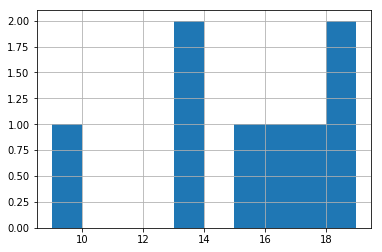

In [19]:
training_data_df[BEST_EPOCH].hist()

In [20]:
training_data_df[TOTAL_DURATION].describe()

count       8.000000
mean     1297.250000
std        10.110108
min      1277.000000
25%      1293.750000
50%      1297.500000
75%      1303.750000
max      1310.000000
Name: Total_Duration(s), dtype: float64

In [21]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
0,8.0,0.810824,0.004679,0.805129,0.807479,0.809627,0.813912,0.818746


In [22]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,8.0,0.810824,0.004679,0.001654,0.806912,0.814736


In [23]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

/home/pedro/anaconda3/envs/allennlp/lib/python3.6/site-packages/researchpy/summary.py:151: RuntimeWarning: invalid value encountered in double_scalars
  l_ci = lambda x: numpy.mean(x) - (1.960 * (numpy.std(x)/numpy.sqrt(x.count() - 1)))
/home/pedro/anaconda3/envs/allennlp/lib/python3.6/site-packages/researchpy/summary.py:154: RuntimeWarning: invalid value encountered in double_scalars
  u_ci = lambda x: numpy.mean(x) + (1.960 * (numpy.std(x)/numpy.sqrt(x.count() - 1)))


,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
FastText,2,0.810252,0.004499,0.003181,0.804017,0.816487
glove,1,0.818746,NaN,NaN,NaN,NaN
none,1,0.807615,NaN,NaN,NaN,NaN
wang2vec,2,0.810238,0.007226,0.005109,0.800224,0.820253
word2vec,2,0.809627,0.001883,0.001331,0.807017,0.812236


In [24]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [25]:
print_anova(EMBEDDING)

Overall model F( 4, 3) =  0.763, p =  0.61322140625969001615
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                 -0.157
Method:                 Least Squares   F-statistic:                    0.7625
Date:                Mon, 20 May 2019   Prob (F-statistic):              0.613
Time:                        18:58:53   Log-Likelihood:                 34.906
No. Observations:                   8   AIC:                            -59.81
Df Residuals:                       3   BIC:                            -59.41
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

/home/pedro/anaconda3/envs/allennlp/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
